# Task 2: Approximating linear vector fields

In [1]:
# Enable these if automatic reloading of modules is wanted

# # Load extension for automatic reload of modules
# %load_ext autoreload
# # Enable autoreload for all modules
# %autoreload 2

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as sk_mse
from scipy.integrate import solve_ivp as scipy_solve_ivp

import linear_vectorfields as lvf
import util

## Loading data

In [3]:

with open('./linear_vectorfield_data_x0.txt', 'r') as file_lvfd_x0:
    lvfd_x0 = np.loadtxt(file_lvfd_x0)

In [4]:
with open('./linear_vectorfield_data_x1.txt', 'r') as file_lvfd_x1:
    lvfd_x1 = np.loadtxt(file_lvfd_x1)

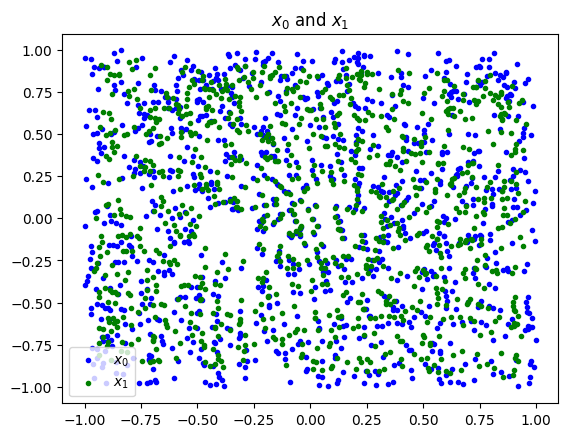

In [5]:
util.point_plot(lvfd_x0[:, 0], lvfd_x0[:, 1], color='blue', label="$x_0$")
util.point_plot(lvfd_x1[:, 0], lvfd_x1[:, 1], color='green', label="$x_1$", title="$x_0$ and $x_1$")
plt.show()

## Part 1

### Compute $\hat{v}$

In [6]:
delta_t = 0.1

# Initialize the LinearVectorfieldApproximation class with our data and a setup delta_t of 0.1
lvfa = lvf.LinearVectorfieldApproximation(x0=lvfd_x0, x1=lvfd_x1, delta_t_setup=delta_t)

print(lvfa.v_hat.shape, lvfa.v_hat, sep="\n")

(1000, 2)
[[ 0.18409949 -0.34489229]
 [ 0.40175684  0.84220121]
 [ 0.15960619  1.10825597]
 ...
 [-0.3170126  -0.17452792]
 [ 0.46427307 -0.33642386]
 [ 0.67015711 -0.42030566]]


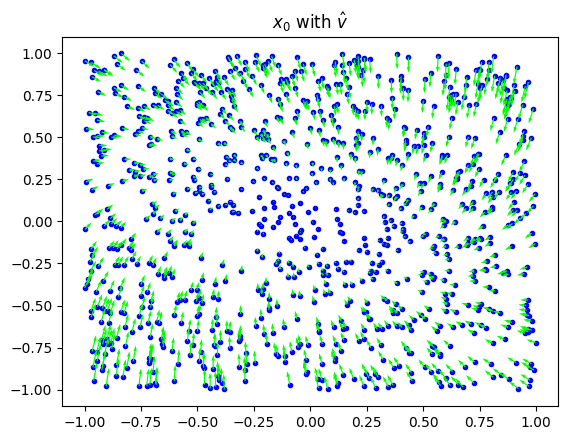

In [7]:
# Plot the direction of v_hat over the initial points

util.arrow_plot(lvfd_x0[:, 0], lvfd_x0[:, 1], lvfa.v_hat[:, 0], lvfa.v_hat[:, 1], color_arrow='lime', color_point='blue', title="$x_0$ with $\hat{v}$")
plt.show()

### Approximate $A$

#### 1. Using $\hat{A}^\top = (X^\top X)^{-1} X^\top F$

In [8]:
# Compute A_hat
lvfa.approximate_A_hat(use_numpy=False)
print("A_hat:", lvfa.A_hat)

# Compute MSE
lvfa.compute_MSE_A_hat()
print("MSE:", lvfa.A_hat_MSE)

A_hat: [[-0.49355245 -0.4638232 ]
 [ 0.23191153 -0.95737573]]
MSE: 0.1640645873069861


#### 2. Using `np.linalg.lstsq`

In [9]:
# Compute A_hat using the numpy lstsq solver
lvfa.approximate_A_hat(use_numpy=True)
print("A_hat numpy:", lvfa.A_hat)

# Compute MSE
lvfa.compute_MSE_A_hat()
print("MSE numpy:", lvfa.A_hat_MSE)

A_hat numpy: [[-0.49355245 -0.4638232 ]
 [ 0.23191153 -0.95737573]]
MSE numpy: 0.16406458730698603


$\Longrightarrow$ The approximations are (nearly) identical, and such are the mean squared errors.

#### Comparison between $\hat{v}$ ("truth") and $\hat{A}x_0$

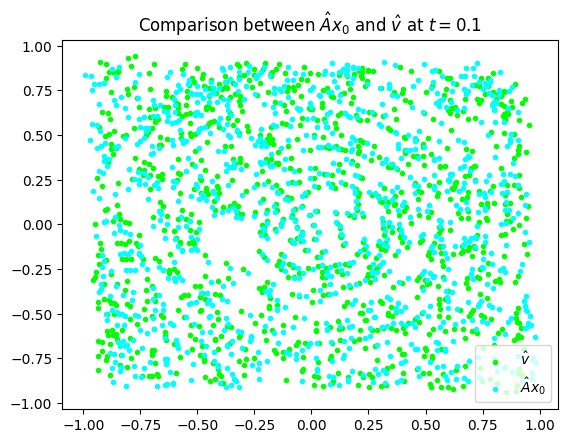

In [10]:
t = 0.1
new_point_in_time_v_hat = lvfa.get_new_point_in_time(t, use_A_hat=False)
new_point_in_time_A_hat = lvfa.get_new_point_in_time(t, use_A_hat=True)

util.point_plot(new_point_in_time_v_hat[:, 0], new_point_in_time_v_hat[:, 1], color='lime', label="$\hat{v}$")
util.point_plot(new_point_in_time_A_hat[:, 0], new_point_in_time_A_hat[:, 1], color='cyan', label="$\hat{A}x_0$", title=f"Comparison between $\hat{{A}}x_0$ and $\hat{{v}}$ at $t={t}$")
plt.show()

For $t=0.1$, $\hat{v}$ represents the data from $x_1$ accurately.
The calculation using $\hat{A}x_0$ is an approximation.

## Part 2

In [11]:
# Define the ODE that will be solved later
def fun_x_dot(t, x, A_hat):
    """x_dot = A_hat @ x"""
    return A_hat @ x.T

In [12]:
# Solve the ODE for a range of start values
lvfa.solve_ivp_range(fun_x_dot, args=([lvfa.A_hat]))
print(lvfa.x_hat.shape, lvfa.x_hat, sep="\n")

(1000, 2)
[[-0.17688678  0.39662104]
 [-0.93406938 -0.38060697]
 [-0.6369426  -0.75571755]
 ...
 [ 0.568651   -0.08255849]
 [-0.62936177  0.58348994]
 [-0.93089697  0.79121337]]


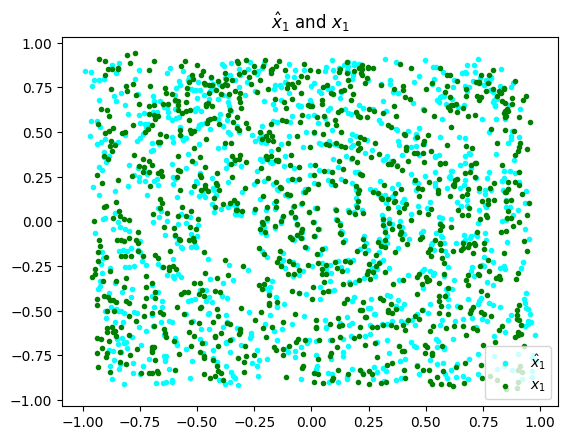

In [13]:
# Plot x_hat and x_1
util.point_plot(lvfa.x_hat[:, 0], lvfa.x_hat[:, 1], color='cyan', label="$\hat{x}_1$")
util.point_plot(lvfa.x1[:, 0], lvfa.x1[:, 1], color='green', label="$x_1$", title="$\hat{x}_1$ and $x_1$")
plt.show()

In [14]:
# Compute MSE for the calculated x_hat
lvfa.compute_MSE_x_hat()
print("MSE x_hat:", lvfa.x_hat_MSE)

MSE x_hat: 0.0015299637979948656


## Part 3
### Plot the Phase Portrait with Trajectory for the initial point (10, 10)

In [15]:
# Solve the ODE for the given starting point
t_end = 100
t_eval = np.linspace(0, t_end, 600)
initial_point = [10, 10]

lvfa.solve_ivp_range(fun_x_dot, t_end=t_end, t_eval=t_eval, y0=initial_point, args=([lvfa.A_hat]))
plot_start_point_results = lvfa.x_hat

In [16]:
# Calculate Grid Points for the Phase Plot by multiplying the matrix A_hat with the grid coordinates
p_min = -10
p_max = 10
stepcount = 100j

ys, xs = np.mgrid[p_min:p_max:stepcount, p_min:p_max:stepcount]

XY = np.empty((2, xs.size))
XY[0, :] = xs.flatten()
XY[1, :] = ys.flatten()

UV = lvfa.A_hat @ XY
U = UV[0, :].reshape(xs.shape)
V = UV[1, :].reshape(ys.shape)

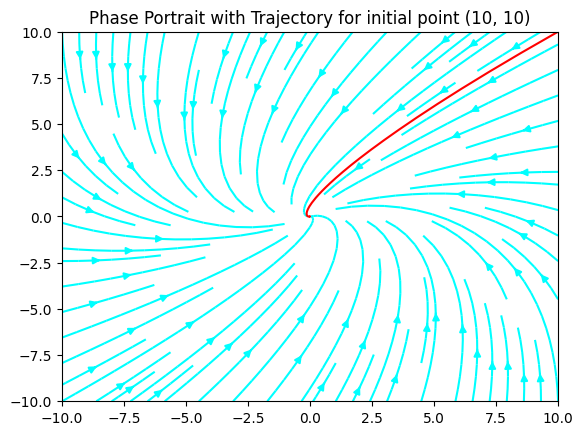

In [17]:
# Plot the things
util.stream_plot(xs, ys, U, V, plot_start_point_results[0,0,:], plot_start_point_results[0,1,:], title=f"Phase Portrait with Trajectory for initial point ({initial_point[0]}, {initial_point[1]})")
plt.show()